In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from sklearn.decomposition import PCA
from src.feature_extraction import scale_density, split_data, scale_cell_counts
from src.cluster_data import *
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
import plotly.express as px
import yaml
from src.feature_extraction import compile_data

assert os.path.isfile("../data/dataset1/density.npy")
assert os.path.isfile("../data/dataset1/cell_counts.npy")

In [2]:
# Aggregate descriptor data if not already aggregated into the proper file
if not os.path.isfile("../data/dataset1/density.npy") or os.path.isfile("../data/dataset1/cell_counts.npy"):
    compile_data(1)

In [3]:
# Initializing Pipeline Steps
num_clusters = 4
pca = PCA(n_components = 3,
          random_state = 0)

kmeans = KMeans(n_clusters = num_clusters,
                n_init = 'auto',
                random_state = 0)

pipeline = Pipeline(steps=[("pca", pca),
                           ("kmeans", kmeans)])

# Density

In [4]:
# Load, Split, Scale data
density = np.load("../data/dataset1/density.npy", allow_pickle=True)
density_train, density_test = split_data(density, itr_cutoff = 5)

density_train, density_test, density = scale_density(density_train, density_test, density)
density_train = density_train.reshape((605,40000))
density_test = density_test.reshape((605,40000))
density = density.reshape((1210,40000))

# For Parameter space partitioning and confusion matrix generation
density_train_labels = pipeline.fit_predict(density_train)
density_predicted_test_labels = pipeline.predict(density_test)

# For identifying representative phenotypes for each cluster
centers = kmeans.cluster_centers_

# For PCA visualization of clusters
density_reduced = pca.transform(density)
density_labels = pipeline.predict(density)

## Confusion Matrix and OOS Accuracy Computation

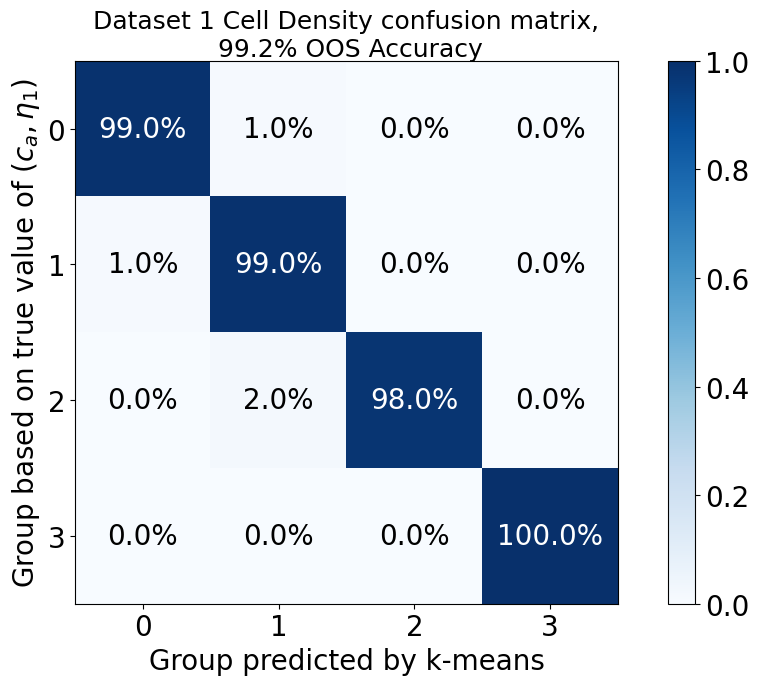

In [5]:
param_ranges = ["(c_a,eta1)"]
    
c_a_base = 0.4
eta1_base = 5
    
param_labels, _ = generate_param_labels(param_ranges,
                                        labels = {'(c_a,eta1)' : density_train_labels.reshape((121,5))},
                                        n_iterations = 5,
                                        n_param_value_combos = 121)

common_label = param_labels['(c_a,eta1)']



c_a_range = np.logspace(np.log2(0.2), np.log2(0.8), 11, base = 2)
c_a_vec = np.repeat(c_a_range,11)

c_a_means = np.zeros(num_clusters)
for c in np.arange(num_clusters):
    c_a_means[c] = np.mean(c_a_vec[common_label == c])
        

common_label_copy = np.zeros(common_label.shape)
density_train_labels_copy = np.zeros(density_train_labels.shape)
density_predicted_test_labels_copy = np.zeros(density_predicted_test_labels.shape)
density_labels_copy = np.zeros(density_labels.shape)
centers_copy = np.copy(centers)

for iold, inew in enumerate(np.argsort(c_a_means)):
    common_label_copy[common_label == inew] = iold
    density_train_labels_copy[density_train_labels == inew] = iold
    density_predicted_test_labels_copy[density_predicted_test_labels == inew] = iold
    density_labels_copy[density_labels == inew] = iold
    centers_copy[iold] = centers[inew]




cm = generate_confusion_matrix(np.repeat(common_label_copy, 5), density_predicted_test_labels_copy, n_clusters = num_clusters)
cm_fig = plot_confusion_matrix_and_OOS(confusion_matrix = cm,
                                       y_true = np.repeat(common_label_copy, 5),
                                       y_pred = density_predicted_test_labels_copy,
                                       n_clusters = num_clusters,
                                       xlabel = "Group predicted by k-means",
                                       ylabel = "Group based on true value of $(c_a, \eta_1)$",
                                       title = "Dataset 1 Cell Density");    



cm_fig.savefig(f"../figures/dataset1/density_confusion_matrix_{num_clusters}_clusters.png")


## Parameter Partition

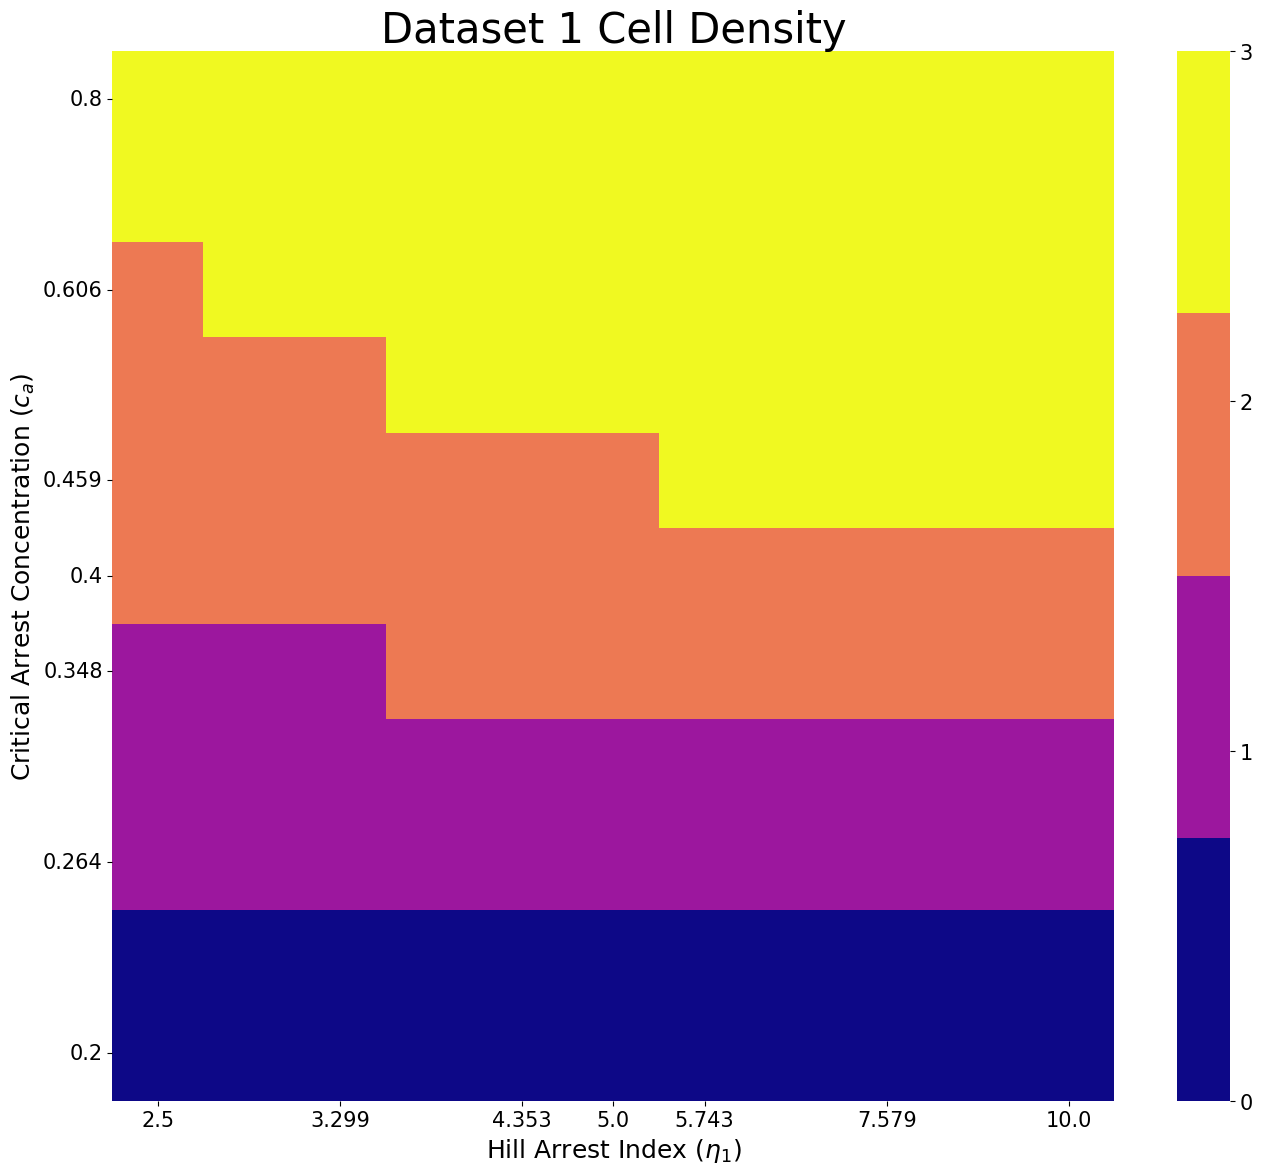

In [6]:
heat_fig = plt.figure(figsize = (14, 12))

eta1_vec = np.round(np.logspace(np.log2(eta1_base / 2), np.log2(2 * eta1_base), 11, base = 2),3)
c_a_vec = np.round(np.logspace(np.log2(c_a_base / 2), np.log2(2 * c_a_base), 11, base = 2),3)
col1 = np.repeat(c_a_vec,11)
col2 = np.tile(eta1_vec,11)


d = {'c_a': col1, 'eta1': col2, 'Cluster': common_label_copy}
df = pd.DataFrame(data=d)
piv_df = df.pivot(index='c_a', columns='eta1', values='Cluster')

plasma = mpl.colormaps['plasma'].resampled(num_clusters)


tick_inds = [i for i in range(len(c_a_vec))]
tick_inds = tick_inds[::2]
tick_inds.append(5)
    
heat_ax = heat_fig.add_subplot(111)
plt.rcParams.update({'font.size': 15})
sns.heatmap(piv_df, cmap = plasma, ax = heat_ax, cbar_kws={'ticks': [i for i in range(num_clusters)]})
heat_ax.set_yticks(heat_ax.get_yticks()[tick_inds])
heat_ax.set_xticks(heat_ax.get_xticks()[tick_inds])
heat_ax.set_yticklabels(c_a_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.set_xticklabels(eta1_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.invert_yaxis()
heat_ax.set_title("Dataset 1 Cell Density", fontsize = 30)
heat_ax.set_xlabel("Hill Arrest Index ($\eta_1$)",fontsize=18)
heat_ax.set_ylabel("Critical Arrest Concentration ($c_a$)",fontsize=18)
heat_fig.tight_layout()
heat_fig.savefig(f"../figures/dataset1/density_parameter_partition_{num_clusters}_clusters.png")

## PCA Projection

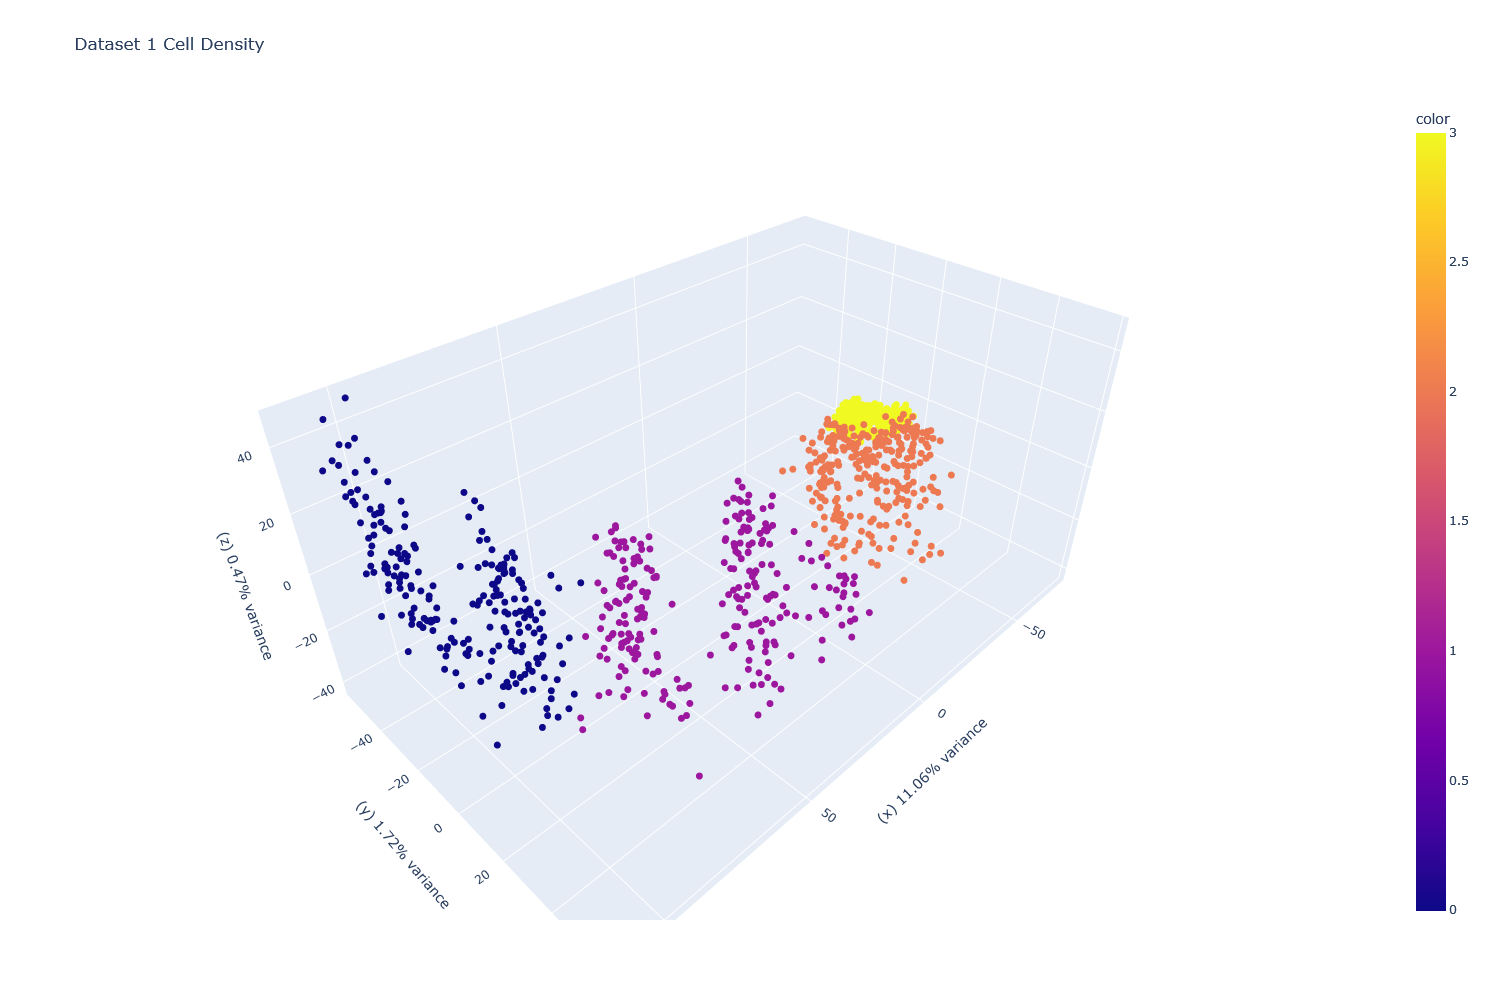

Cell Density: Cumulative Explained Variance = 13.25%


In [7]:
var = pca.explained_variance_ratio_
pca_fig = px.scatter_3d(x=density_reduced[:, 0],
                        y=density_reduced[:, 1],
                        z=density_reduced[:, 2],
                        color=density_labels_copy, labels = {'x': f"(x) {100*var[0]:.2f}% variance",
                                                              'y': f"(y) {100*var[1]:.2f}% variance",
                                                              'z':f"(z) {100*var[2]:.2f}% variance"},
                        title = "Dataset 1 Cell Density")

pca_fig.update_traces(marker={'size': 4})
pca_fig.update_layout(autosize=False,
                             width = 1200,
                             height = 1000)
     
pca_fig.show()
print(f"Cell Density: Cumulative Explained Variance = {100*np.sum(var[:3]):.2f}%")

## Locate Representative Phenotypes

In [8]:
# Find the sample closest to the centroid in each cluster
phenotype_inds = np.empty(num_clusters, dtype = int)

for c in np.arange(num_clusters):
    phenotype_inds[c] = np.argmin(np.linalg.norm(density_reduced - centers_copy[c], axis = 1))
    
    # Verify that the chosen sample belongs to the correct cluster (this should be the case if k-means is working) 
    assert int(c) == int(density_labels_copy[phenotype_inds[c]])
        
np.save(f"../results/dataset1/density_phenotype_inds_{num_clusters}_clusters.npy", phenotype_inds, allow_pickle = True)

# Cell Counts

In [9]:
# Load, Split, Scale data
cell_counts = np.load("../data/dataset1/cell_counts.npy", allow_pickle=True)
cell_counts_train, cell_counts_test = split_data(cell_counts, itr_cutoff = 5)


cell_counts_train, cell_counts_test, cell_counts = scale_cell_counts(cell_counts_train, cell_counts_test, cell_counts)
cell_counts_train = cell_counts_train.reshape((605,4*241))
cell_counts_test = cell_counts_test.reshape((605,4*241))
cell_counts = cell_counts.reshape((1210, 4*241))

# For Parameter space partitioning and confusion matrix generation
cell_counts_train_labels = pipeline.fit_predict(cell_counts_train)
cell_counts_predicted_test_labels = pipeline.predict(cell_counts_test)

# For identifying representative phenotypes for each cluster
centers = kmeans.cluster_centers_

# For PCA visualization of clusters
cell_counts_reduced = pca.transform(cell_counts)
cell_counts_labels = pipeline.predict(cell_counts)

## Confusion Matrix and OOS Accuracy Computation

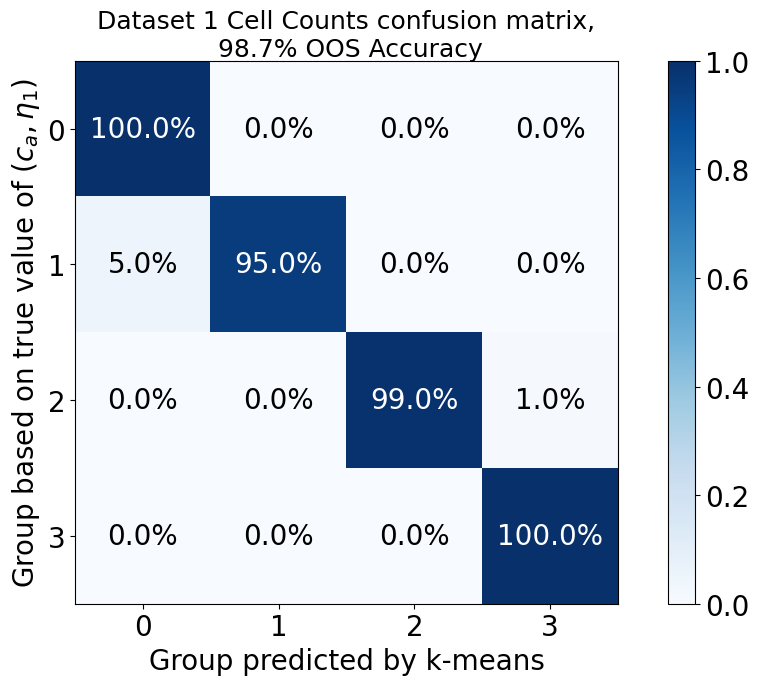

In [10]:
# Assign most common label among 5 training iterations to each parameter region 
param_ranges = ["(c_a,eta1)"]
param_labels, _ = generate_param_labels(param_ranges,
                                        labels = {'(c_a,eta1)' : cell_counts_train_labels.reshape((121,5))},
                                        n_iterations = 5,
                                        n_param_value_combos = 121)

common_label = param_labels['(c_a,eta1)']

c_a_range = np.logspace(np.log2(0.2), np.log2(0.8), 11, base = 2)
c_a_vec = np.repeat(c_a_range,11)

c_a_means = np.zeros(num_clusters)
for c in np.arange(num_clusters):
    c_a_means[c] = np.mean(c_a_vec[common_label == c])

# Relabel clusters by increasing mean value of c_a 
common_label_copy = np.zeros(common_label.shape)
cell_counts_train_labels_copy = np.zeros(cell_counts_train_labels.shape)
cell_counts_predicted_test_labels_copy = np.zeros(cell_counts_predicted_test_labels.shape)
cell_counts_labels_copy = np.zeros(cell_counts_labels.shape)
centers_copy = np.zeros(centers.shape)

for iold, inew in enumerate(np.argsort(c_a_means)):
    common_label_copy[common_label == inew] = iold
    cell_counts_train_labels_copy[cell_counts_train_labels == inew] = iold
    cell_counts_predicted_test_labels_copy[cell_counts_predicted_test_labels == inew] = iold
    cell_counts_labels_copy[cell_counts_labels == inew] = iold
    centers_copy[iold] = centers[inew]




cm = generate_confusion_matrix(np.repeat(common_label_copy, 5), cell_counts_predicted_test_labels_copy, n_clusters = num_clusters)
cm_fig = plot_confusion_matrix_and_OOS(confusion_matrix = cm,
                                       y_true = np.repeat(common_label_copy, 5),
                                       y_pred = cell_counts_predicted_test_labels_copy,
                                       n_clusters = num_clusters,
                                       xlabel = "Group predicted by k-means",
                                       ylabel = "Group based on true value of $(c_a, \eta_1)$",
                                       title = "Dataset 1 Cell Counts");   



cm_fig.savefig(f"../figures/dataset1/cell_counts_confusion_matrix_{num_clusters}_clusters.png")

## Parameter Partition

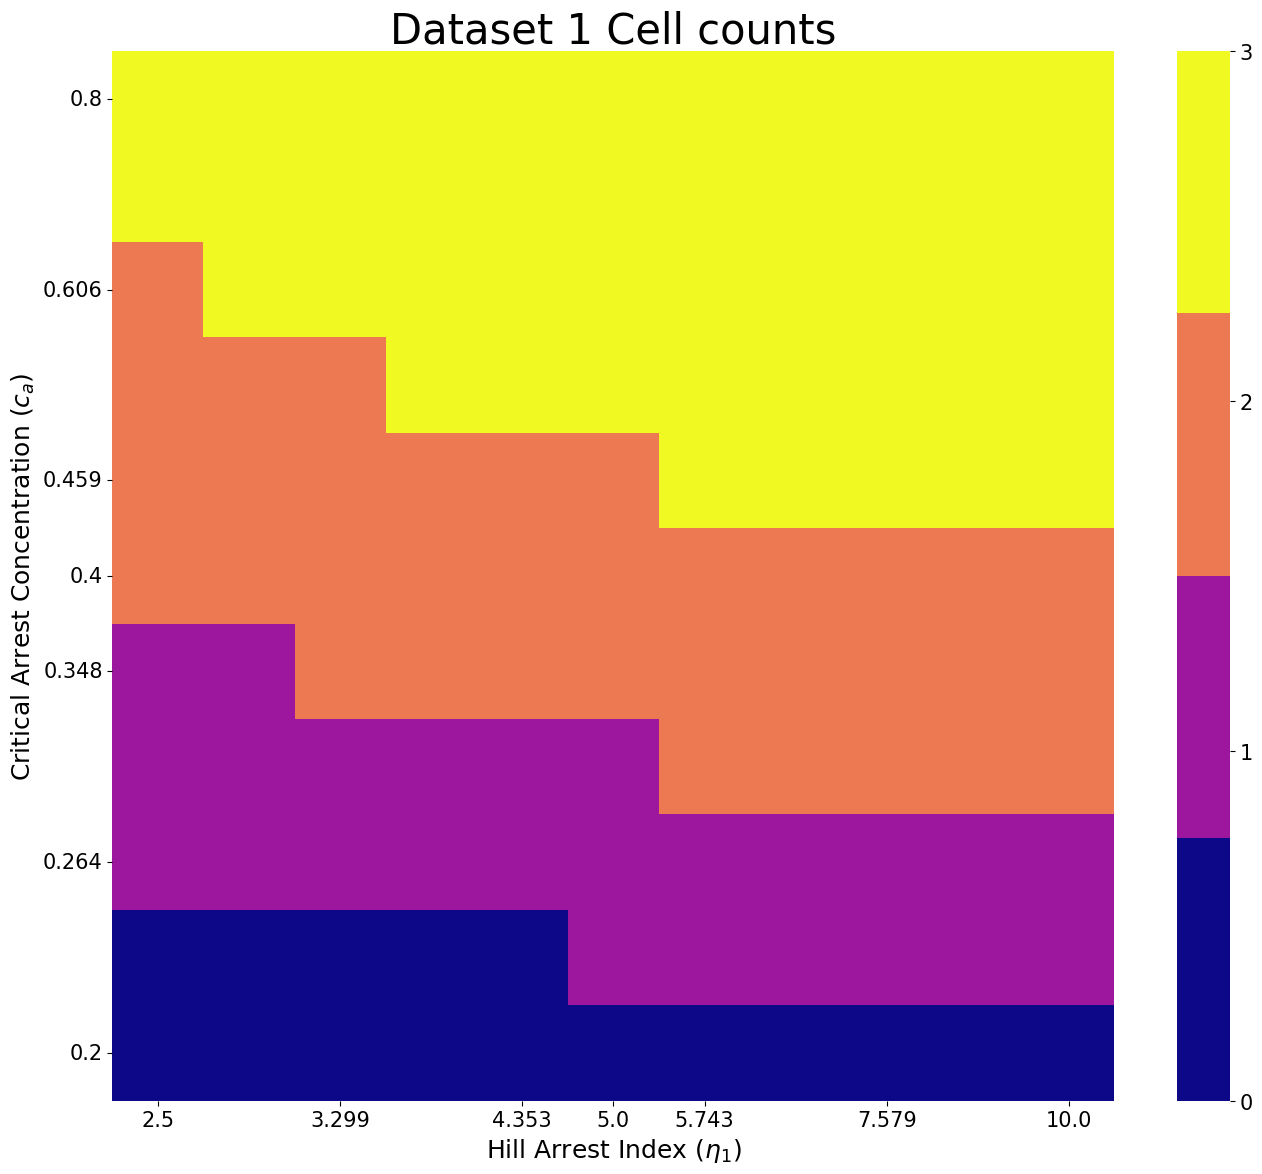

In [11]:
heat_fig = plt.figure(figsize = (14, 12))

eta1_vec = np.round(np.logspace(np.log2(eta1_base / 2), np.log2(2 * eta1_base), 11, base = 2),3)
c_a_vec = np.round(np.logspace(np.log2(c_a_base / 2), np.log2(2 * c_a_base), 11, base = 2),3)
col1 = np.repeat(c_a_vec,11)
col2 = np.tile(eta1_vec,11)


d = {'c_a': col1, 'eta1': col2, 'Cluster': common_label_copy}
df = pd.DataFrame(data=d)
piv_df = df.pivot(index='c_a', columns='eta1', values='Cluster')

plasma = mpl.colormaps['plasma'].resampled(num_clusters)


tick_inds = [i for i in range(len(c_a_vec))]
tick_inds = tick_inds[::2]
tick_inds.append(5)
    
heat_ax = heat_fig.add_subplot(111)
plt.rcParams.update({'font.size': 15})
sns.heatmap(piv_df, cmap = plasma, ax = heat_ax, cbar_kws={'ticks': [i for i in range(num_clusters)]})
heat_ax.set_yticks(heat_ax.get_yticks()[tick_inds])
heat_ax.set_xticks(heat_ax.get_xticks()[tick_inds])
heat_ax.set_yticklabels(c_a_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.set_xticklabels(eta1_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.invert_yaxis()
heat_ax.set_title("Dataset 1 Cell counts", fontsize = 30)
heat_ax.set_xlabel("Hill Arrest Index ($\eta_1$)",fontsize=18)
heat_ax.set_ylabel("Critical Arrest Concentration ($c_a$)",fontsize=18)
heat_fig.tight_layout()
heat_fig.savefig(f"../figures/dataset1/cell_counts_parameter_partition_{num_clusters}_clusters.png")

## PCA Projection

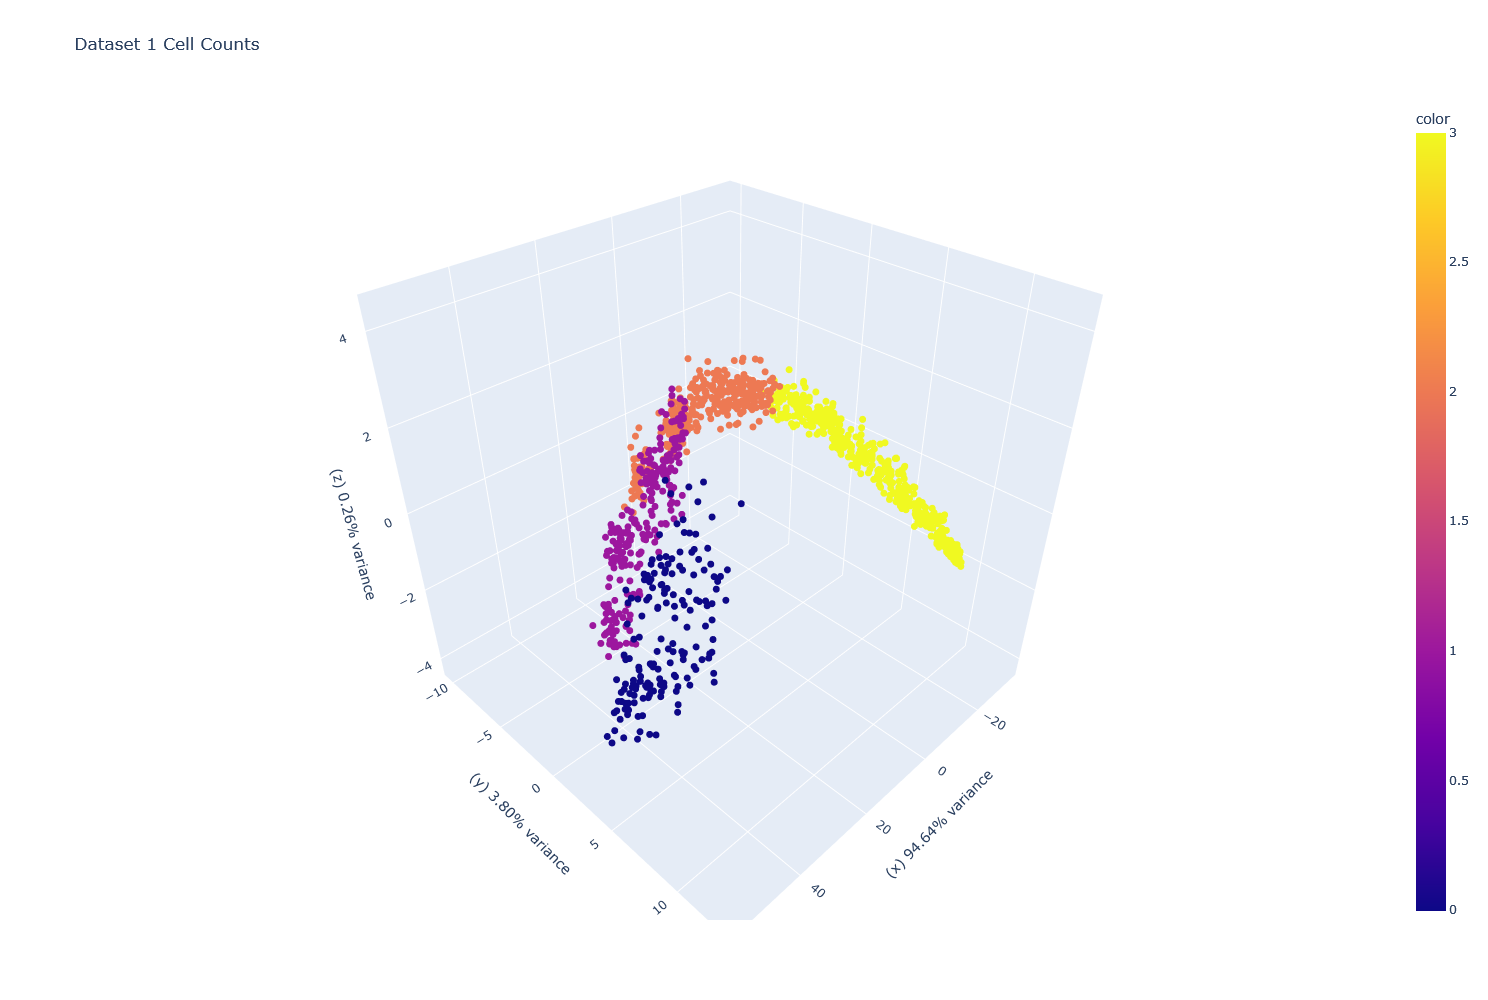

Cell Counts: Cumulative Explained Variance = 98.71%


In [12]:
var = pca.explained_variance_ratio_
pca_fig = px.scatter_3d(x=cell_counts_reduced[:, 0],
                        y=cell_counts_reduced[:, 1],
                        z=cell_counts_reduced[:, 2],
                        color=cell_counts_labels_copy, labels = {'x': f"(x) {100*var[0]:.2f}% variance",
                                                              'y': f"(y) {100*var[1]:.2f}% variance",
                                                              'z':f"(z) {100*var[2]:.2f}% variance"},
                        title = "Dataset 1 Cell Counts")

pca_fig.update_traces(marker={'size': 4})
pca_fig.update_layout(autosize=False,
                             width = 1200,
                             height = 1000)
     
pca_fig.show()
print(f"Cell Counts: Cumulative Explained Variance = {100*np.sum(var[:3]):.2f}%")

## Locate Representative Phenotypes

In [13]:
# Find the sample closest to the centroid in each cluster
phenotype_inds = np.empty(num_clusters, dtype = int)

for c in np.arange(num_clusters):
    phenotype_inds[c] = np.argmin(np.linalg.norm(cell_counts_reduced - centers_copy[c], axis = 1))
    # Verify that the chosen sample belongs to the correct cluster (this should be the case if k-means is working) 
    assert int(c) == int(cell_counts_labels_copy[phenotype_inds[c]]) 
np.save(f"../results/dataset1/cell_counts_phenotype_inds_{num_clusters}_clusters.npy", phenotype_inds, allow_pickle = True)